In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [2]:
# Change these 
training_data_dir = "../../training_data/v2.2"
split_dir = "../../training_data/splits/v2"

In [3]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [4]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')

In [7]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
# reason: the last 3 colors are the same
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

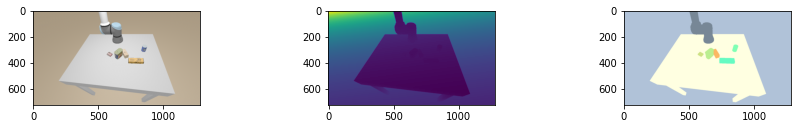

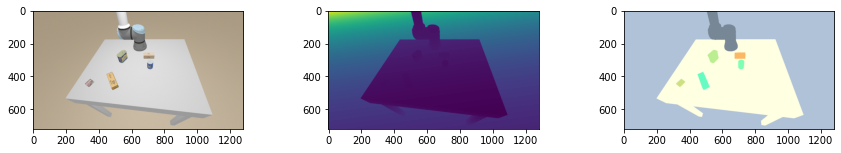

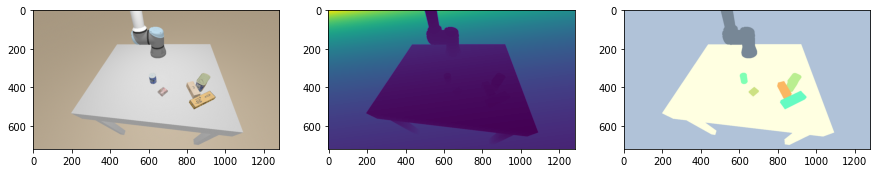

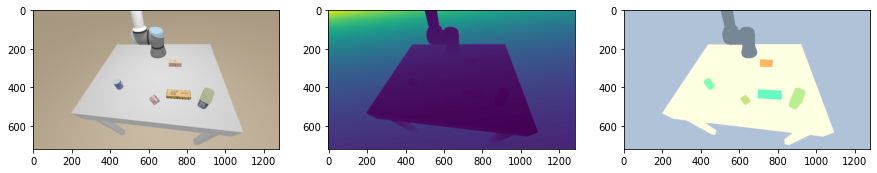

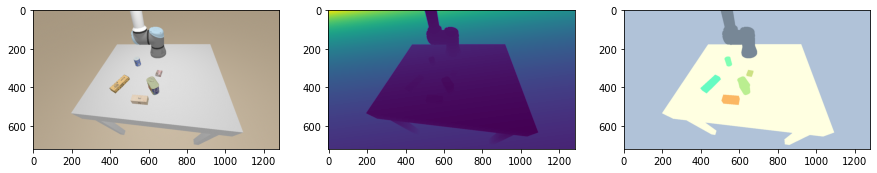

In [21]:
for i in reversed(range(5)):
    rgb = np.array(Image.open(rgb_files[i])) / 255   # convert 0-255 to 0-1
    depth = np.array(Image.open(depth_files[i])) / 1000   # convert from mm to m
    label = np.array(Image.open(label_files[i]))
    plt.figure(figsize=(15, 10))
    plt.subplot(i+1, 3, 1)
    plt.imshow(rgb)
    plt.subplot(i+1, 3, 2)
    plt.imshow(depth)
    plt.subplot(i+1, 3, 3)
    plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [22]:
meta = load_pickle(meta_files[0])
meta.keys()

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

In [23]:
meta['object_names'], meta['object_ids']

(['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block'],
 array([35, 39, 48, 51, 58], dtype=int64))

In [24]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
print(poses_world)
print(box_sizes)

[[[ 8.96165788e-01  4.43719357e-01 -2.05287742e-09  1.54664963e-01]
  [-4.43719357e-01  8.96165788e-01 -1.38711505e-08 -2.47322485e-01]
  [-4.31517888e-09  1.33417517e-08  1.00000000e+00  1.49999792e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 2.52058744e-01 -9.67711926e-01 -4.74869807e-07 -7.39289522e-02]
  [ 9.67711926e-01  2.52058744e-01 -1.68100215e-07 -1.65959626e-01]
  [ 2.82367694e-07 -4.17166063e-07  1.00000000e+00  3.53019834e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 5.71150661e-01  8.20845246e-01 -7.03646137e-08  1.78418741e-01]
  [-8.20845246e-01  5.71150661e-01  2.75676761e-08  1.15660978e-02]
  [ 6.28175982e-08  4.20131592e-08  1.00000000e+00  4.21280004e-02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-1.54490232e-01  9.87785459e-01 -2.03189254e-02  3.06937266e-02]
  [-9.87928748e-01 -1.54210210e-01  1.47043318e-02  3.25209089e-02]
  [ 1.13913417e-02  2.23453231e-02  9.9968

## Lift depth to point cloud

In [25]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]

In [30]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

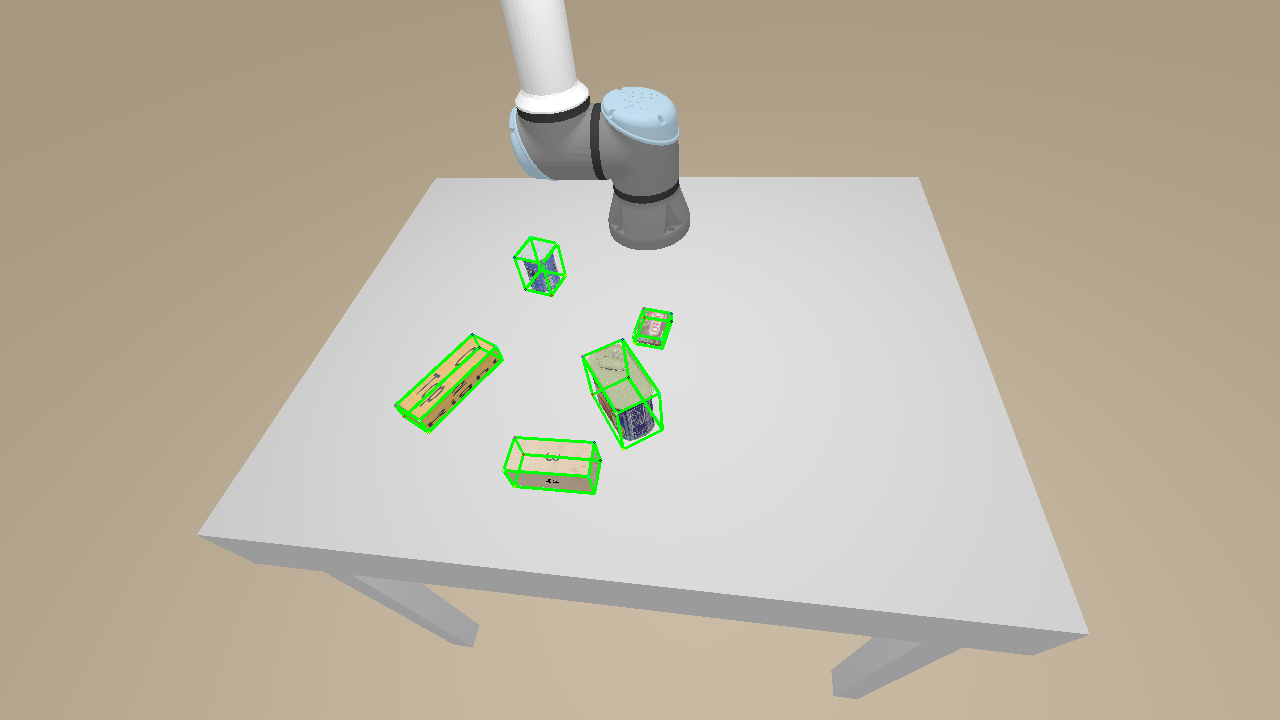

In [27]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [28]:
load_pickle("../../testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

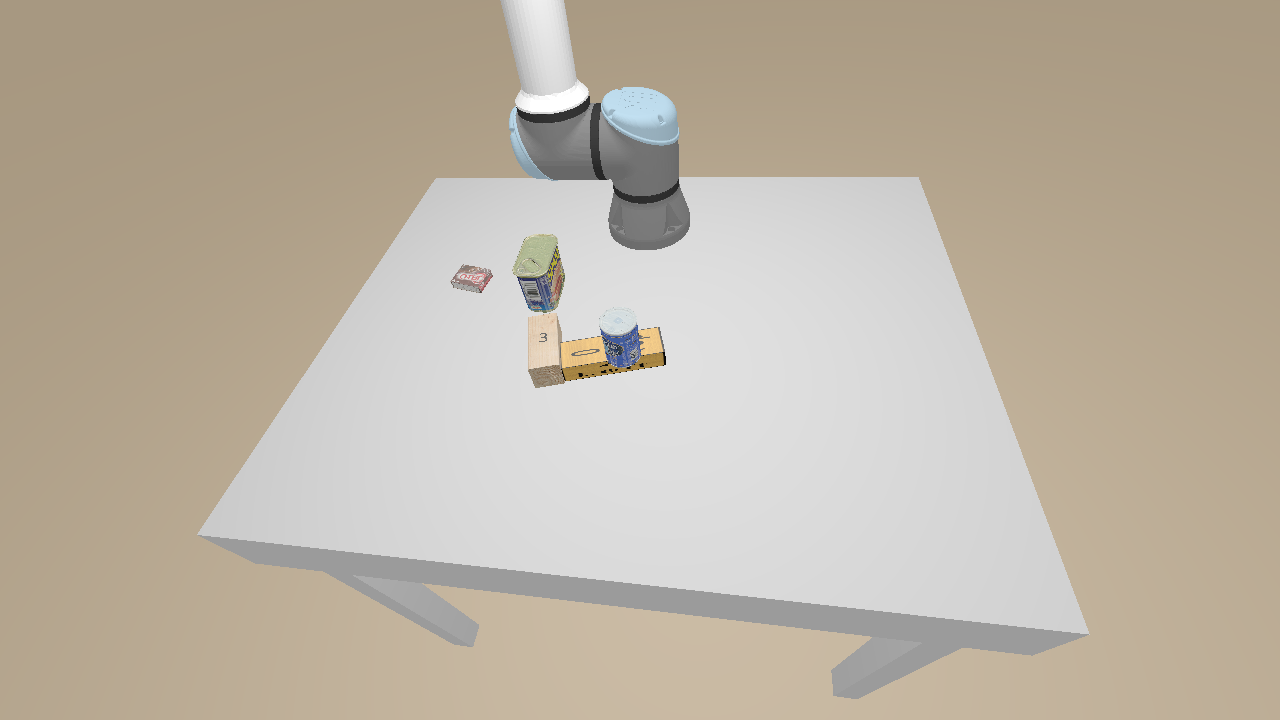

In [29]:
Image.open("../../testing_data/v2.2/1-1-1_color_kinect.png")